# Feature: Out-Of-Fold Predictions from a Siamese LSTM with Attention

<img src="assets/siamese-lstm-attention.png" alt="Network Architecture" style="height: 700px;" />

## Imports

This utility package imports `numpy`, `pandas`, `matplotlib` and a helper `kg` module into the root namespace.

In [1]:
from pygoose import *

In [2]:
import gc

In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import *

In [4]:
kg.gpu.cuda_use_gpus(gpu_ids=0)

In [5]:
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


## Config

Automatically discover the paths to various data folders and compose the project structure.

In [6]:
project = kg.Project.discover()

Identifier for storing these features on disk and referring to them later.

In [7]:
feature_list_id = 'oofp_nn_siamese_lstm_attention'

Make subsequent NN runs reproducible.

In [8]:
RANDOM_SEED = 42

In [9]:
np.random.seed(RANDOM_SEED)

## Read data

Word embedding lookup matrix.

In [10]:
embedding_matrix = kg.io.load(project.aux_dir + 'fasttext_vocab_embedding_matrix.pickle')

Padded sequences of word indices for every question.

In [11]:
X_train_q1 = kg.io.load(project.preprocessed_data_dir + 'sequences_q1_fasttext_train.pickle')
X_train_q2 = kg.io.load(project.preprocessed_data_dir + 'sequences_q2_fasttext_train.pickle')

In [12]:
X_test_q1 = kg.io.load(project.preprocessed_data_dir + 'sequences_q1_fasttext_test.pickle')
X_test_q2 = kg.io.load(project.preprocessed_data_dir + 'sequences_q2_fasttext_test.pickle')

In [13]:
y_train = kg.io.load(project.features_dir + 'y_train.pickle')

Word embedding properties.

In [14]:
EMBEDDING_DIM = embedding_matrix.shape[-1]
VOCAB_LENGTH = embedding_matrix.shape[0]
MAX_SEQUENCE_LENGTH = X_train_q1.shape[-1]

In [15]:
print(EMBEDDING_DIM, VOCAB_LENGTH, MAX_SEQUENCE_LENGTH)

300 101442 30


## Define models

In [16]:
def contrastive_loss(y_true, y_pred):
    """
    Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """    
    margin = 1
    return K.mean((1 - y_true) * K.square(y_pred) +
                   y_true * K.square(K.maximum(margin - y_pred, 0)))

In [17]:
class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification" by using a context
    vector to assist the attention.
    
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.

    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    
    The dimensions are inferred based on the output shape of the RNN.
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
    """

    def __init__(self, init='glorot_uniform',
                 kernel_regularizer=None, bias_regularizer=None,
                 kernel_constraint=None, bias_constraint=None,  **kwargs):
        
        self.supports_masking = True
        self.init = initializers.get(init)
        self.kernel_initializer = initializers.get('glorot_uniform')

        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(
            (input_shape[-1], 1),
            initializer=self.kernel_initializer,
            name='{}_W'.format(self.name),
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint
        )
        self.b = self.add_weight(
            (input_shape[1],),
            initializer='zero',
            name='{}_b'.format(self.name),
            regularizer=self.bias_regularizer,
            constraint=self.bias_constraint
        )
        self.u = self.add_weight(
            (input_shape[1],),
            initializer=self.kernel_initializer,
            name='{}_u'.format(self.name),
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint
        )
        self.built = True

    def compute_mask(self, input, mask):
        return None

    def call(self, x, mask=None):
        multdata = K.dot(x, self.kernel)     # (x, 40, 300) * (300, 1) => (x, 40, 1)
        multdata = K.squeeze(multdata, -1)   # (x, 40)
        multdata = multdata + self.b         # (x, 40) + (40,)

        multdata = K.tanh(multdata)          # (x, 40)

        multdata = multdata * self.u         # (x, 40) * (40, 1) => (x, 1)
        multdata = K.exp(multdata)           # (x, 1)

        # Apply mask after the exp. will be re-normalized next.
        if mask is not None:
            mask = K.cast(mask, K.floatx())  # (x, 40)
            multdata = mask * multdata       # (x, 40) * (x, 40, )

        # In some cases, especially in the early stages of training, the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        multdata /= K.cast(K.sum(multdata, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        multdata = K.expand_dims(multdata)
        weighted_input = x * multdata
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1],)

In [18]:
def create_model(params):
    embedding_layer = Embedding(
        VOCAB_LENGTH,
        EMBEDDING_DIM,
        weights=[embedding_matrix],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False,
    )
    lstm_layer = LSTM(
        params['num_lstm'],
        dropout=params['lstm_dropout_rate'],
        recurrent_dropout=params['lstm_dropout_rate'],
        return_sequences=True,
    )
    attention_layer = AttentionWithContext()

    sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_1 = embedding_layer(sequence_1_input)
    x1 = attention_layer(lstm_layer(embedded_sequences_1))

    sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_2 = embedding_layer(sequence_2_input)
    y1 = attention_layer(lstm_layer(embedded_sequences_2))

    merged = concatenate([x1, y1])
    merged = Dropout(params['dense_dropout_rate'])(merged)
    merged = BatchNormalization()(merged)

    merged = Dense(params['num_dense'], activation='relu')(merged)
    merged = Dropout(params['dense_dropout_rate'])(merged)
    merged = BatchNormalization()(merged)

    output = Dense(1, activation='sigmoid')(merged)

    model = Model(
        inputs=[sequence_1_input, sequence_2_input],
        outputs=output
    )

    model.compile(
        loss=contrastive_loss,
        optimizer='nadam',
        metrics=['accuracy']
    )

    return model

In [19]:
def predict(model, X_q1, X_q2):
    """
    Mirror the pairs, compute two separate predictions, and average them.
    """
    
    y1 = model.predict([X_q1, X_q2], batch_size=1024, verbose=1).reshape(-1)   
    y2 = model.predict([X_q2, X_q1], batch_size=1024, verbose=1).reshape(-1)    
    return (y1 + y2) / 2

## Partition the data

In [20]:
NUM_FOLDS = 5

In [21]:
kfold = StratifiedKFold(
    n_splits=NUM_FOLDS,
    shuffle=True,
    random_state=RANDOM_SEED
)

Create placeholders for out-of-fold predictions.

In [22]:
y_train_oofp = np.zeros_like(y_train, dtype='float64')

In [23]:
y_test_oofp = np.zeros((len(X_test_q1), NUM_FOLDS))

## Define hyperparameters

In [24]:
BATCH_SIZE = 2048

In [25]:
MAX_EPOCHS = 200

Best values picked by Bayesian optimization.

In [26]:
model_params = {
    'dense_dropout_rate': 0.164,
    'lstm_dropout_rate': 0.324,
    'num_dense': 132,
    'num_lstm': 254,
}

The path where the best weights of the current model will be saved.

In [27]:
model_checkpoint_path = project.temp_dir + 'fold-checkpoint-' + feature_list_id + '.h5'

## Fit the folds and compute out-of-fold predictions

In [28]:
%%time

# Iterate through folds.
for fold_num, (ix_train, ix_val) in enumerate(kfold.split(X_train_q1, y_train)):
    
    # Augment the training set by mirroring the pairs.
    X_fold_train_q1 = np.vstack([X_train_q1[ix_train], X_train_q2[ix_train]])
    X_fold_train_q2 = np.vstack([X_train_q2[ix_train], X_train_q1[ix_train]])

    X_fold_val_q1 = np.vstack([X_train_q1[ix_val], X_train_q2[ix_val]])
    X_fold_val_q2 = np.vstack([X_train_q2[ix_val], X_train_q1[ix_val]])

    # Ground truth should also be "mirrored".
    y_fold_train = np.concatenate([y_train[ix_train], y_train[ix_train]])
    y_fold_val = np.concatenate([y_train[ix_val], y_train[ix_val]])
    
    print()
    print(f'Fitting fold {fold_num + 1} of {kfold.n_splits}')
    print()
    
    # Compile a new model.
    model = create_model(model_params)

    # Train.
    model.fit(
        [X_fold_train_q1, X_fold_train_q2], y_fold_train,
        validation_data=([X_fold_val_q1, X_fold_val_q2], y_fold_val),

        batch_size=BATCH_SIZE,
        epochs=MAX_EPOCHS,
        verbose=1,
        
        callbacks=[
            # Stop training when the validation loss stops improving.
            EarlyStopping(
                monitor='val_loss',
                min_delta=0.001,
                patience=3,
                verbose=1,
                mode='auto',
            ),
            # Save the weights of the best epoch.
            ModelCheckpoint(
                model_checkpoint_path,
                monitor='val_loss',
                save_best_only=True,
                verbose=2,
            ),
        ],
    )
        
    # Restore the best epoch.
    model.load_weights(model_checkpoint_path)
    
    # Compute out-of-fold predictions.
    y_train_oofp[ix_val] = predict(model, X_train_q1[ix_val], X_train_q2[ix_val])
    y_test_oofp[:, fold_num] = predict(model, X_test_q1, X_test_q2)
    
    # Clear GPU memory.
    K.clear_session()
    del X_fold_train_q1
    del X_fold_train_q2
    del X_fold_val_q1
    del X_fold_val_q2
    del model
    gc.collect()


Fitting fold 1 of 5

Train on 646862 samples, validate on 161718 samples
Epoch 1/200
646862/646862 [==============================] - 79s - loss: 0.1842 - acc: 0.7181 - val_loss: 0.2147 - val_acc: 0.6840
Epoch 2/200
646862/646862 [==============================] - 77s - loss: 0.1550 - acc: 0.7703 - val_loss: 0.1556 - val_acc: 0.7790
Epoch 3/200
646862/646862 [==============================] - 78s - loss: 0.1422 - acc: 0.7920 - val_loss: 0.1360 - val_acc: 0.8013
Epoch 4/200
646862/646862 [==============================] - 78s - loss: 0.1335 - acc: 0.8069 - val_loss: 0.1327 - val_acc: 0.8066
Epoch 5/200
646862/646862 [==============================] - 77s - loss: 0.1268 - acc: 0.8174 - val_loss: 0.1281 - val_acc: 0.8144
Epoch 6/200
646862/646862 [==============================] - 78s - loss: 0.1214 - acc: 0.8265 - val_loss: 0.1198 - val_acc: 0.8286
Epoch 7/200
646862/646862 [==============================] - 78s - loss: 0.1169 - acc: 0.8334 - val_loss: 0.1191 - val_acc: 0.8290
Epoch 8/2

646862/646862 [==============================] - 73s - loss: 0.1216 - acc: 0.8258 - val_loss: 0.1214 - val_acc: 0.8262
Epoch 7/200
646862/646862 [==============================] - 71s - loss: 0.1173 - acc: 0.8333 - val_loss: 0.1222 - val_acc: 0.8253
Epoch 8/200
646862/646862 [==============================] - 71s - loss: 0.1130 - acc: 0.8399 - val_loss: 0.1181 - val_acc: 0.8325
Epoch 9/200
646862/646862 [==============================] - 71s - loss: 0.1099 - acc: 0.8451 - val_loss: 0.1170 - val_acc: 0.8340
Epoch 10/200
646862/646862 [==============================] - 72s - loss: 0.1072 - acc: 0.8495 - val_loss: 0.1178 - val_acc: 0.8333
Epoch 11/200
646862/646862 [==============================] - 77s - loss: 0.1044 - acc: 0.8538 - val_loss: 0.1172 - val_acc: 0.8350
Epoch 12/200
646862/646862 [==============================] - 71s - loss: 0.1019 - acc: 0.8581 - val_loss: 0.1134 - val_acc: 0.8402
Epoch 13/200
646862/646862 [==============================] - 74s - loss: 0.1002 - acc: 0.86

646864/646864 [==============================] - 72s - loss: 0.1331 - acc: 0.8070 - val_loss: 0.1310 - val_acc: 0.8093
Epoch 5/200
646864/646864 [==============================] - 72s - loss: 0.1265 - acc: 0.8181 - val_loss: 0.1239 - val_acc: 0.8209
Epoch 6/200
646864/646864 [==============================] - 71s - loss: 0.1211 - acc: 0.8267 - val_loss: 0.1224 - val_acc: 0.8248
Epoch 7/200
646864/646864 [==============================] - 72s - loss: 0.1167 - acc: 0.8340 - val_loss: 0.1245 - val_acc: 0.8199
Epoch 8/200
646864/646864 [==============================] - 79s - loss: 0.1128 - acc: 0.8402 - val_loss: 0.1154 - val_acc: 0.8355
Epoch 9/200
646864/646864 [==============================] - 72s - loss: 0.1092 - acc: 0.8460 - val_loss: 0.1162 - val_acc: 0.8362
Epoch 10/200
646864/646864 [==============================] - 72s - loss: 0.1067 - acc: 0.8500 - val_loss: 0.1149 - val_acc: 0.8379
Epoch 11/200
646864/646864 [==============================] - 72s - loss: 0.1038 - acc: 0.8549

646866/646866 [==============================] - 85s - loss: 0.1073 - acc: 0.8490 - val_loss: 0.1143 - val_acc: 0.8370
Epoch 11/200
646866/646866 [==============================] - 80s - loss: 0.1045 - acc: 0.8539 - val_loss: 0.1170 - val_acc: 0.8352
Epoch 12/200
646866/646866 [==============================] - 86s - loss: 0.1026 - acc: 0.8568 - val_loss: 0.1140 - val_acc: 0.8396
Epoch 13/200
646866/646866 [==============================] - 86s - loss: 0.1003 - acc: 0.8604 - val_loss: 0.1147 - val_acc: 0.8386
Epoch 00012: early stopping
2345796/2345796 [==============================] - 124s   

Fitting fold 5 of 5

Train on 646866 samples, validate on 161714 samples
Epoch 1/200
646866/646866 [==============================] - 86s - loss: 0.1839 - acc: 0.7182 - val_loss: 0.2120 - val_acc: 0.6538
Epoch 2/200
646866/646866 [==============================] - 86s - loss: 0.1550 - acc: 0.7698 - val_loss: 0.1508 - val_acc: 0.7914
Epoch 3/200
646866/646866 [==============================] - 8

In [29]:
cv_score = log_loss(y_train, y_train_oofp)
print('CV score:', cv_score)

CV score: 0.360265255459


## Save features

In [30]:
features_train = y_train_oofp.reshape((-1, 1))

In [31]:
features_test = np.mean(y_test_oofp, axis=1).reshape((-1, 1))

In [32]:
print('X train:', features_train.shape)
print('X test: ', features_test.shape)

X train: (404290, 1)
X test:  (2345796, 1)


In [33]:
feature_names = [feature_list_id]

In [34]:
project.save_features(features_train, features_test, feature_names, feature_list_id)

## Explore

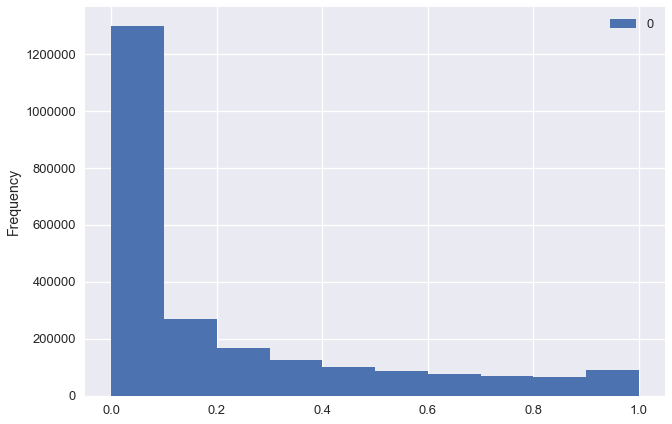

In [35]:
pd.DataFrame(features_test).plot.hist()